In [32]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier, IslationForest, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

In [33]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [34]:
Train_df = pd.read_csv('Train_df.csv')


In [35]:
Train_df.shape

(5410, 57)

In [36]:
Train_df.head()

,Unnamed: 0,Provider,BeneID,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,admitteddays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_Cancer,...,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,fraudstate,fraudcountry,isductable,issamecode,isadmitted,isdischarge,PotentialFraud
0,0,PRV51001,24,25,4185.600000,213.600000,1.000000,0.600000,0.760000,0.200000,...,0,0,0,0,9,5,14,5,5,No
1,1,PRV51003,117,132,4588.409091,502.166667,2.424242,0.424242,0.606061,0.075758,...,0,0,0,23,27,63,54,62,62,Yes
2,2,PRV51004,138,149,350.134228,2.080537,0.000000,0.429530,0.590604,0.107383,...,0,0,0,53,67,7,121,0,0,No
3,3,PRV51005,495,1165,241.124464,3.175966,0.000000,0.365665,0.583691,0.141631,...,0,0,0,2,506,48,913,0,0,Yes
4,4,PRV51007,58,72,468.194444,45.333333,0.222222,0.361111,0.555556,0.166667,...,0,0,0,0,2,5,55,3,3,No


In [37]:
Train_df.drop('Unnamed: 0', axis='columns',inplace=True)

In [38]:
Train_df.shape

(5410, 56)

In [39]:
Train_df['PotentialFraud']=Train_df['PotentialFraud'].replace({'Yes':1, 'No':0})


In [40]:
y=Train_df['PotentialFraud']
X=Train_df.drop(['Provider','PotentialFraud'], axis = 1)

In [16]:
X_1, X_test, y_1, y_test =model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [41]:

def get_threshould_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()

#determining best threshold
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

#pridicting Yq for given Xq with best threshold:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)

In [42]:
def model_performence_check(model,X_train,X_test,y_train,y_test):
    
    y_train_pred = model.predict_proba(X_train)[:,1]    
    y_test_pred = model.predict_proba(X_test)[:,1]
    
    train_fpr, train_tpr, tr_thresholds = get_threshould_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshould_fpr_tpr(y_test, y_test_pred)
    
    #plot Roc_AUC_curve
    draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print(best_t)
    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3)) 

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for test data")
    
    actual_output = y_test
    pred_output = predict_with_best_t(y_test_pred, best_t)
    
    model_f1_score = metrics.f1_score(actual_output,pred_output)
    print("Model test F1 score is : ",model_f1_score)
    
    model_AUC_score = metrics.auc(test_fpr, test_tpr)
    print("Model test AUC score is : ",model_AUC_score)
    
    return (model_f1_score, model_AUC_score)

In [43]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

# Logistic regression

In [13]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_1,y_1)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.93266463        nan 0.93372074        nan 0.93239868
        nan 0.93319163        nan 0.93319303        nan 0.93345688
        nan 0.93372074]
  warnings.warn(
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [       nan 0.93313386        nan 0.93245903        nan 0.93298707
        nan 0.9324003         nan 0.93272308        nan 0.93257634
        nan 0.93231228]
  warnings.warn(


tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.9337207354357752


C:\Users\soumya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:

logreg2=LogisticRegression(C=0.01,penalty="l2")
logreg2.fit(X_1,y_1)

filename = 'logistic_model.sav'
pickle.dump(logreg2, open(filename, 'wb'))

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# loading the model

In [32]:
import pickle
filename = 'logistic_model.sav'
loaded_model1 = pickle.load(open(filename, 'rb'))
print("score",loaded_model1.score(X_test,y_test))

score 0.9343807763401109


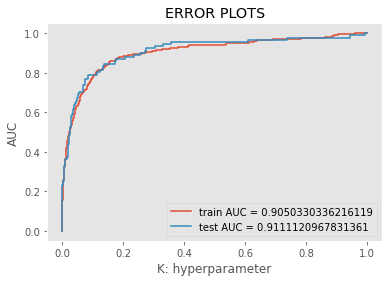

the maximum value of tpr*(1-fpr) 0.7231986672219908 for threshold 0.067
0.06695926806888942
Model test F1 score is :  0.4858044164037855
Model test AUC score is :  0.9111120967831361


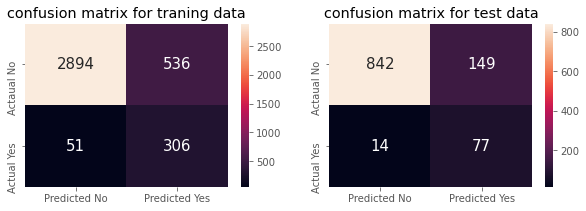

In [33]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model1,X_1,X_test,y_1,y_test)

# Decision Tree

In [17]:

DT_model = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [10, 50, 100, 500, 1000,1500], 'min_samples_split': [5, 10,20, 45, 75, 100, 135, 270, 500,100,1500]}

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(X_1,y_1)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)
print("roc_auc :",DT_model_CV.best_score_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
tuned hpyerparameters :(best parameters)  {'max_depth': 500, 'min_samples_split': 270}
roc_auc : 0.9148962938629509


In [34]:

# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 500, min_samples_split = 270)
DT_model2=DT_model2.fit(X_1,y_1)

In [35]:
filename = 'decision_model.sav'
pickle.dump(DT_model2, open(filename, 'wb'))

In [36]:
import pickle
filename = 'decision_model.sav'
loaded_model2 = pickle.load(open(filename, 'rb'))
print("score",loaded_model2.score(X_test,y_test))

score 0.822550831792976


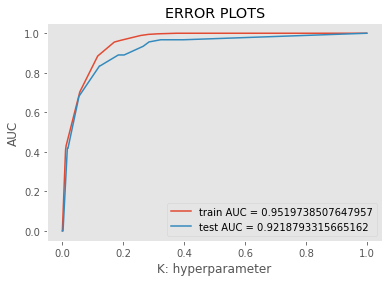

the maximum value of tpr*(1-fpr) 0.7925504895835885 for threshold 0.565
0.5649066174775197
Model test F1 score is :  0.4576271186440678
Model test AUC score is :  0.9218793315665162


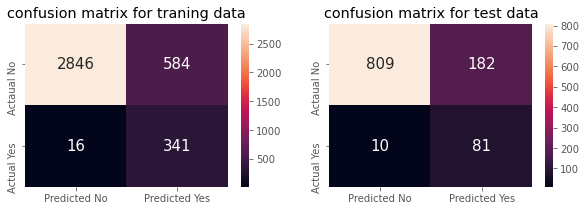

In [37]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model2,X_1,X_test,y_1,y_test)

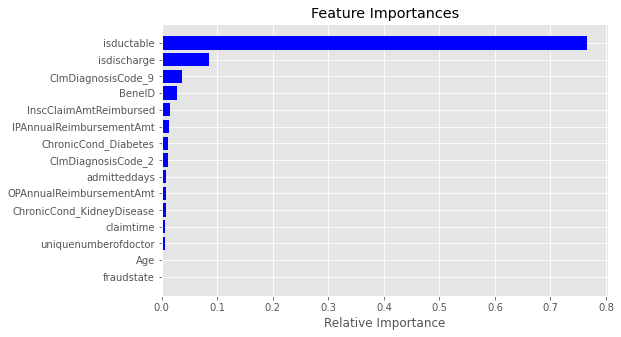

In [38]:
features = X.columns
importances =loaded_model2.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(8,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Random forst

In [23]:



RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = { 
    'n_estimators': [50,100,300, 500,700,1000,1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,20,25,50,100,150,200,400,500,1000,1500],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_1, y_1)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)

print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}
roc_auc : 0.9340778799782825


In [39]:
RF2 = RandomForestClassifier(n_estimators = 50,max_features='log2',max_depth=5,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42)
RF2=RF2.fit(X_1,y_1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s


building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50

building tree 5 of 50building tree 6 of 50

building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50building tree 14 of 50

building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s


building tree 26 of 50building tree 27 of 50


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50building tree 35 of 50

building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished


In [40]:
filename = 'randomforest_model.sav'
pickle.dump(RF2, open(filename, 'wb'))


In [41]:
filename = 'randomforest_model.sav'
loaded_model3 = pickle.load(open(filename, 'rb'))
print("score",loaded_model3.score(X_test,y_test))

score 0.8817005545286506


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of 

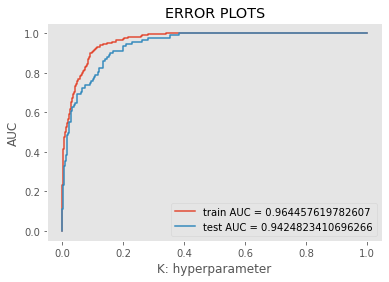

the maximum value of tpr*(1-fpr) 0.8256265771614768 for threshold 0.462
0.46163664086863604
Model test F1 score is :  0.5244755244755245
Model test AUC score is :  0.9424823410696266


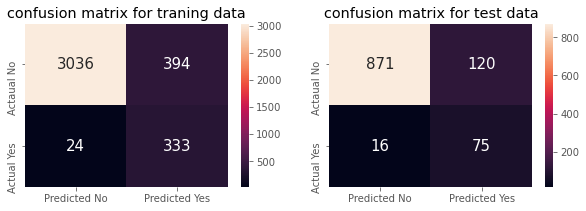

In [42]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model3,X_1,X_test,y_1,y_test)

# Xgboost

In [24]:
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,0.5,1,1.5,10,50,100,500,1500] , "n_estimators" : [5,10,50, 75, 100,300,500,700,1000,1500]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_1,y_1)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
tuned hpyerparameters :(best parameters)  {'n_estimators': 700, 'eta': 0.1}
roc_auc : 0.9260070057533409


In [43]:
XGB2 = xgb.XGBClassifier(eta=0.1,n_estimators=700,n_jobs=-1)
XGB2=XGB2.fit(X_1,y_1)

In [44]:
filename = 'xgboost_model.sav'
pickle.dump(XGB2, open(filename, 'wb'))

In [45]:
import pickle
filename = 'xgboost_model.sav'
loaded_model4 = pickle.load(open(filename, 'rb'))
print("score",loaded_model4.score(X_test,y_test))

score 0.933456561922366


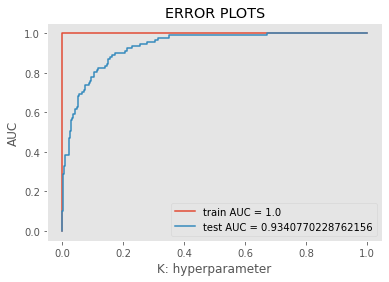

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.944
0.94413155
Model test F1 score is :  0.47244094488188976
Model test AUC score is :  0.9340770228762156


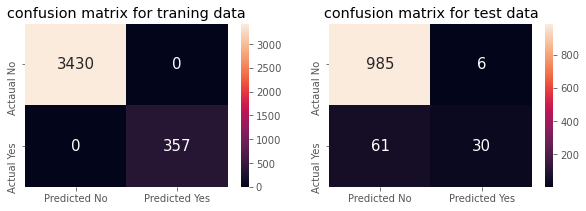

In [46]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model4 ,X_1,X_test,y_1,y_test)

# SVM model(rbf kernal)

In [25]:
#from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC # "Support vector classifier"  
param_grid = {'kernel': ['rbf'],
              'C': [1, 10, 100,500,700,900,1000,1500]}

base_estimator = SVC(gamma='scale')
SVM_CV=GridSearchCV(base_estimator, param_grid, cv=5).fit(X_1, y_1)

print("tuned hpyerparameters :(best parameters) ",SVM_CV.best_params_)
print("roc_auc :",SVM_CV.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1500, 'kernel': 'rbf'}
roc_auc : 0.9302896797872451


In [47]:
classifier = SVC(kernel='rbf', C=1500,random_state=0,probability=True)  
classifier.fit(X_1,y_1)  

SVC(C=1500, probability=True, random_state=0)

In [48]:
filename = 'svm_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [49]:
filename = 'svm_model.sav'
loaded_model5 = pickle.load(open(filename, 'rb'))
print("score",loaded_model5.score(X_test,y_test))

score 0.9390018484288355


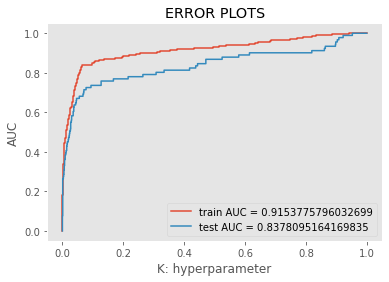

the maximum value of tpr*(1-fpr) 0.7864370237891075 for threshold 0.074
0.07368385336177494
Model test F1 score is :  0.5477178423236514
Model test AUC score is :  0.8378095164169835


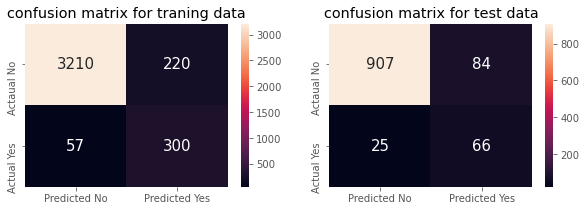

In [50]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model5 ,X_1,X_test,y_1,y_test)

# SVM(polynomial kernal)

In [26]:
#from sklearn.experimental import enable_halving_search_cv
# "Support vector classifier"  
param_grid = {'kernel': ['poly'],
              'C': [1, 10, 100,500,700,900,1000,1500]}

base_estimator = SVC(gamma='scale')
SVM_CV=GridSearchCV(base_estimator, param_grid, cv=5).fit(X_1, y_1)

print("tuned hpyerparameters :(best parameters) ",SVM_CV.best_params_)
print("roc_auc :",SVM_CV.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1500, 'kernel': 'poly'}
roc_auc : 0.9331941457565798


In [51]:
classifier = SVC(kernel='poly', C=1500,random_state=0,probability=True)  
classifier.fit(X_1,y_1)  

SVC(C=1500, kernel='poly', probability=True, random_state=0)

In [52]:
filename = 'svm_modelpoly.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [53]:
filename = 'svm_modelpoly.sav'
loaded_modelpoly = pickle.load(open(filename, 'rb'))
print("score",loaded_modelpoly.score(X_test,y_test))

score 0.9408502772643254


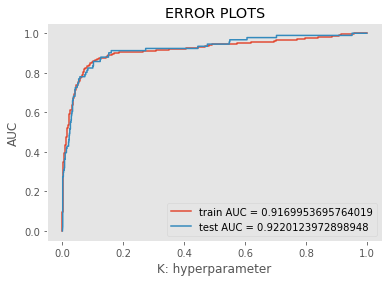

the maximum value of tpr*(1-fpr) 0.7711917420029237 for threshold 0.065
0.06465897971888727
Model test F1 score is :  0.5672727272727273
Model test AUC score is :  0.9220123972898948


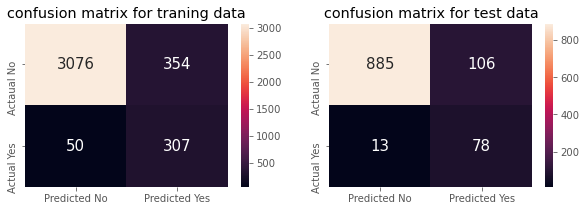

In [54]:
model_f1_score, model_AUC_score = model_performence_check(loaded_modelpoly ,X_1,X_test,y_1,y_test)

# catBoost

In [33]:
!pip install catboost

     |████████████████████████████████| 67.3MB 52kB/s 


In [ ]:

cbc = CatBoostClassifier()
grid = {'max_depth': [3,4,5,10,15,50,100,150,200],'n_estimators':[10,50,75,100,500,1000,1500]}
gscv = GridSearchCV (estimator = cbc, param_grid = grid, scoring ='accuracy', cv = 5)
gscv.fit(X_1,y_1)
print("tuned hpyerparameters :(best parameters) ",gscv.best_params_)
print("roc_auc :",gscv.best_score_)

Streaming output truncated to the last 5000 lines.
84:	learn: 0.1133969	total: 415ms	remaining: 73.3ms
85:	learn: 0.1132749	total: 420ms	remaining: 68.3ms
86:	learn: 0.1124798	total: 424ms	remaining: 63.3ms
87:	learn: 0.1119311	total: 428ms	remaining: 58.4ms
88:	learn: 0.1115047	total: 436ms	remaining: 53.9ms
89:	learn: 0.1109978	total: 442ms	remaining: 49.1ms
90:	learn: 0.1104021	total: 446ms	remaining: 44.1ms
91:	learn: 0.1099723	total: 451ms	remaining: 39.2ms
92:	learn: 0.1093464	total: 456ms	remaining: 34.4ms
93:	learn: 0.1089506	total: 461ms	remaining: 29.4ms
94:	learn: 0.1084726	total: 466ms	remaining: 24.5ms
95:	learn: 0.1079917	total: 471ms	remaining: 19.6ms
96:	learn: 0.1073272	total: 475ms	remaining: 14.7ms
97:	learn: 0.1071156	total: 480ms	remaining: 9.79ms
98:	learn: 0.1069062	total: 484ms	remaining: 4.89ms
99:	learn: 0.1062874	total: 489ms	remaining: 0us
Learning rate set to 0.136619
0:	learn: 0.5432964	total: 4.98ms	remaining: 493ms
1:	learn: 0.4256360	total: 10ms	remaini

In [ ]:
from catboost import CatBoostClassifier
clf=CatBoostClassifier(max_depth=5,n_estimators=100)
clf.fit(X_1,y_1)

Learning rate set to 0.150268
0:	learn: 0.5282880	total: 59.9ms	remaining: 5.93s
1:	learn: 0.3706935	total: 69.6ms	remaining: 3.41s
2:	learn: 0.3056131	total: 79.8ms	remaining: 2.58s
3:	learn: 0.2529632	total: 89.7ms	remaining: 2.15s
4:	learn: 0.2272602	total: 99.6ms	remaining: 1.89s
5:	learn: 0.2106405	total: 109ms	remaining: 1.71s
6:	learn: 0.1998684	total: 119ms	remaining: 1.58s
7:	learn: 0.1884522	total: 129ms	remaining: 1.49s
8:	learn: 0.1799065	total: 140ms	remaining: 1.41s
9:	learn: 0.1724433	total: 150ms	remaining: 1.35s
10:	learn: 0.1662177	total: 163ms	remaining: 1.32s
11:	learn: 0.1628655	total: 173ms	remaining: 1.27s
12:	learn: 0.1595501	total: 184ms	remaining: 1.23s
13:	learn: 0.1563123	total: 194ms	remaining: 1.19s
14:	learn: 0.1543065	total: 209ms	remaining: 1.18s
15:	learn: 0.1516584	total: 219ms	remaining: 1.15s
16:	learn: 0.1489167	total: 229ms	remaining: 1.11s
17:	learn: 0.1460958	total: 238ms	remaining: 1.08s
18:	learn: 0.1446327	total: 248ms	remaining: 1.06s
19:	le

In [ ]:
filename = 'drive/MyDrive/self/cat_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [34]:
filename = 'drive/MyDrive/self/cat_model.sav'
loaded_model6 = pickle.load(open(filename, 'rb'))
print("score",loaded_model6.score(X_test,y_test))

score 0.9328404189772027


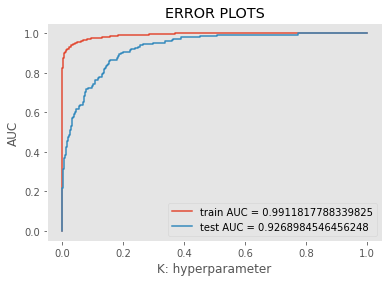

the maximum value of tpr*(1-fpr) 0.9112910470310573 for threshold 0.223
Model test F1 score is :  0.5688622754491018
Model test AUC score is :  0.9268984546456248


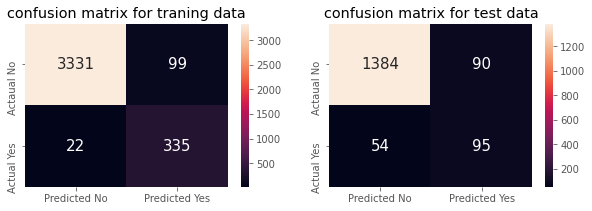

In [35]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model6 ,X_1,X_test,y_1,y_test)

# Custom ensembele model

Divide the data 80 and 20

In [44]:
Xtrain, X_test, ytrain, y_test =model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

Divide the data 50 and 50

In [45]:
Xtrain1, Xtrain2, ytrain1, ytrain2= model_selection.train_test_split(Xtrain, ytrain, test_size=0.5, random_state=0)

In [46]:
Xtrain1['fraudprovider']=ytrain1

<ipython-input-46-76f2a30b51d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtrain1['fraudprovider']=ytrain1


Divide the data random with replacement

In [47]:
def samplingdata():
    D1=Xtrain1.sample(frac=0.5, replace=True)
    y11train=D1['fraudprovider']
    x11train=D1.drop('fraudprovider',  axis='columns')
    return(x11train,y11train)

# **base classifier 1**

In [48]:
import numpy
def logistic(x,y):
    #rid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
    logreg=LogisticRegression(C=0.1,penalty="l2")
    logreg.fit(x,y)
    filename = 'basemodel1.sav'
    pickle.dump(logreg, open(filename, 'wb'))
    return(logreg)

# **base classifier 2**

In [49]:

def decesiontree(x,y):
    model1 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 10, min_samples_split = 270)
    model1.fit(x,y)
    filename = 'basemodel2.sav'
    pickle.dump(model1, open(filename, 'wb'))
    return(model1)

# base classifier 3

In [50]:
def randomforest(x,y):
    RF2 = RandomForestClassifier(n_estimators = 50,max_features='log2',max_depth=5,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42)
    RF2=RF2.fit(x,y)
    filename = 'basemodel3.sav'
    pickle.dump(RF2, open(filename, 'wb'))
    return(RF2)

# **base classifer 4**

In [51]:
def polysvm(x,y):
    from sklearn.svm import SVC # "Support vector classifier"  
    classifier = SVC(kernel='poly', C=1500,random_state=0,probability=True)  
    classifier.fit(x,y)
    filename = 'basemodel4.sav'
    pickle.dump(classifier, open(filename, 'wb'))
    return(classifier) 

# **base classifer 5**

In [52]:
def rbfsvm(x,y):
    classifier = SVC(kernel='rbf', C=1500,random_state=0,probability=True)  
    classifier.fit(x,y)
    filename = 'basemodel5.sav'
    pickle.dump(classifier, open(filename, 'wb'))
    return(classifier) 

# **base classifier 6**

In [53]:
def xgboost(x,y):
    XGB2 = xgb.XGBClassifier(eta=0.1,n_estimators=700,n_jobs=-1)
    XGB2=XGB2.fit(x,y)
    filename = 'basemodel6.sav'
    pickle.dump(XGB2, open(filename, 'wb'))
    return(XGB2)

# **prediction**
Divide the Data in k number of part

In [54]:
def metadataset(k):
    yhat=[]
    yhattest=[]
    for i in range(k):
        t=i%6
        if t==0:
            x,y=samplingdata()
            model=logistic(x,y)
            ypred=model.predict(Xtrain2)
            ytest=model.predict(X_test)
        elif t==1:
            x,y=samplingdata()
            model= decesiontree(x,y)
            ypred=model.predict(Xtrain2)
            ytest=model.predict(X_test)
        elif t==2:
            x,y=samplingdata()
            model=randomforest(x,y)
            ypred=model.predict(Xtrain2)
            ytest=model.predict(X_test)
        elif t==3:
            x,y=samplingdata()
            model=polysvm(x,y)
            ypred=model.predict(Xtrain2)
            ytest=model.predict(X_test)
        elif t==4:
            x,y=samplingdata()
            model=rbfsvm(x,y)
            ypred=model.predict(Xtrain2)
            ytest=model.predict(X_test)
        else:
            x,y=samplingdata()
            model=xgboost(x,y)
            ypred=model.predict(Xtrain2)
            ytest=model.predict(X_test)
        yhat.append(ypred)
        yhattest.append(ytest)

    return(np.transpose(yhat),np.transpose(yhattest))


# **meta classiifer1**
Xgboost

In [55]:
k=10
# k is hyperparametr can be anything
trainmeta,testmeta=metadataset(10)
trainmetay=numpy.array(ytrain2)
testmetay=numpy.array(y_test)
XGB = xgb.XGBClassifier()
parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,0.5,1,1.5,10,50,100,500,1500] , "n_estimators" : [5,10,50, 75, 100,300,500,700,1000,1500]}
XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(trainmeta,trainmetay)
print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print('XGBOOST')
print("accuracy :",XGB_CV.best_score_)

C:\Users\soumya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50building tree 7 of 50

building tree 8 of 50building tree 9 of 50

building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50building tree 18 of 50

building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50building tree 25 of 50

building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50building tree 30 of 50building tree 31 of 50


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50building tree 27 of 50

building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50building tree 35 of 50

building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished



building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
tuned hpyerparameters :(best parameters)  {'n_estimators': 5, 'eta': 1}
XGBOOST
accuracy : 0.9232882131554188


In [56]:
XGB2 = xgb.XGBClassifier(eta=1,n_estimators=5,n_jobs=-1)
XGB2=XGB2.fit(trainmeta,trainmetay)
filename = 'bestmetaxgboost_model.sav'
pickle.dump(XGB2, open(filename, 'wb'))

In [57]:
filename = 'bestmetaxgboost_model.sav'
bestmeta= pickle.load(open(filename, 'rb'))
print("score",bestmeta.score(testmeta,testmetay))

score 0.9380776340110906


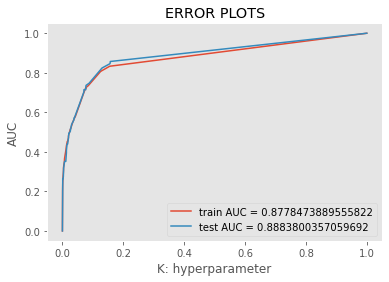

the maximum value of tpr*(1-fpr) 0.706482593037215 for threshold 0.16
0.1595383
Model test F1 score is :  0.5084745762711865
Model test AUC score is :  0.8883800357059692


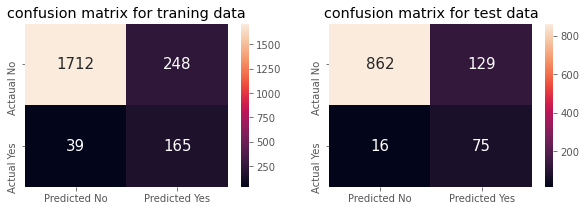

In [58]:
model_f1_score, model_AUC_score = model_performence_check(bestmeta ,trainmeta,testmeta,trainmetay,testmetay)

# **meta classiifer2**
Ranomforest

In [59]:
RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = { 
    'n_estimators': [50,100,300, 500,700,1000,1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,20,25,50,100,150,200,400,500,1000,1500],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(trainmeta,trainmetay)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)

print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 50}
roc_auc : 0.870738551518168


In [60]:
RF2 = RandomForestClassifier(n_estimators =50,max_features='auto',max_depth=4,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42)
RF2=RF2.fit(trainmeta,trainmetay)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.1s


building tree 1 of 50building tree 2 of 50building tree 3 of 50


building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50building tree 23 of 50

building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50building tree 42 of 50
building tree 43 of 50

building tree 44 of 

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [61]:
filename = 'metarandomforest_model.sav'
pickle.dump(RF2, open(filename, 'wb'))

In [62]:
filename = 'metarandomforest_model.sav'
loaded_model3 = pickle.load(open(filename, 'rb'))
print("score",loaded_model3.score(testmeta,testmetay))

score 0.8696857670979667


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of 

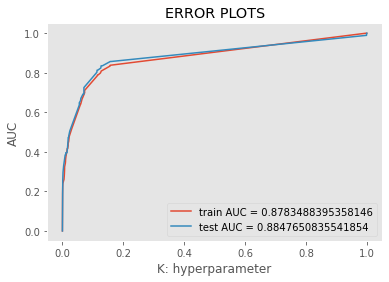

the maximum value of tpr*(1-fpr) 0.7065126050420169 for threshold 0.313
0.3126518783810938
Model test F1 score is :  0.4770642201834862
Model test AUC score is :  0.8847650835541854


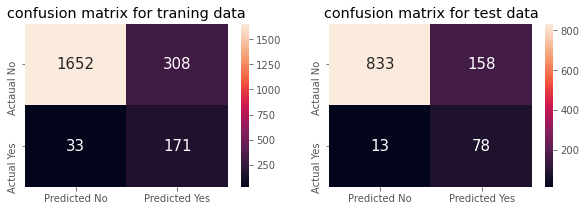

In [63]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model3 ,trainmeta,testmeta,trainmetay,testmetay)

# **Meta classifier 3**
 Decision tree

In [64]:
DT_model = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [10, 50, 100, 500, 1000,1500], 'min_samples_split': [5, 10,20, 45, 75, 100, 135, 270, 500,100,1500]}

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(trainmeta,trainmetay)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)
print("roc_auc :",DT_model_CV.best_score_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
tuned hpyerparameters :(best parameters)  {'max_depth': 10, 'min_samples_split': 135}
roc_auc : 0.8679912269785962


In [65]:
# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 10, min_samples_split = 135)
DT_model2=DT_model2.fit(trainmeta,trainmetay)

In [66]:
filename = 'metadecision_model.sav'
pickle.dump(DT_model2, open(filename, 'wb'))

In [67]:
filename = 'metadecision_model.sav'
loaded_model2 = pickle.load(open(filename, 'rb'))
print("score",loaded_model2.score(testmeta,testmetay))

score 0.8650646950092421


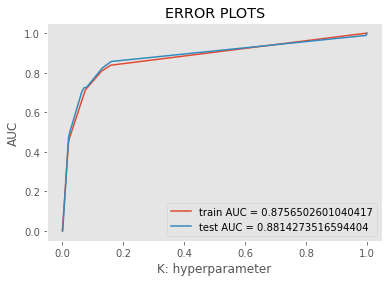

the maximum value of tpr*(1-fpr) 0.7052295918367347 for threshold 0.498
0.49847405900305175
Model test F1 score is :  0.4756097560975609
Model test AUC score is :  0.8814273516594404


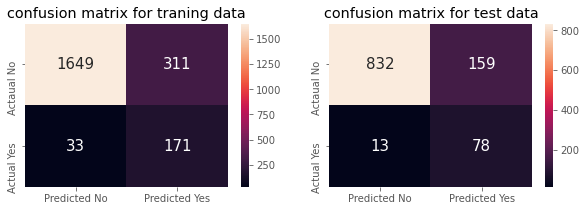

In [68]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model2  ,trainmeta,testmeta,trainmetay,testmetay)

# **Meta classifier 4**
logistic regression

In [69]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(trainmeta,trainmetay)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.9283794162826421


C:\Users\soumya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.90573477        nan 0.92282813        nan 0.92837942
        nan 0.92560591        nan 0.92514508        nan 0.92514508
        nan 0.92514508]
  warnings.warn(
C:\Users\soumya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [       nan 0.90573019        nan 0.92467665        nan 0.92934897
        nan 0.9297085         nan 0.92981117        nan 0.92970848
        nan 0.92970848]
  warnings.warn(


In [70]:
logreg2=LogisticRegression(C=0.1,penalty="l2")
logreg2.fit(trainmeta,trainmetay)
filename = 'metalogistic_model.sav'
pickle.dump(logreg2, open(filename, 'wb'))

In [71]:
import pickle
filename = 'metalogistic_model.sav'
loaded_model1 = pickle.load(open(filename, 'rb'))
print("score",loaded_model1.score(testmeta,testmetay))

score 0.9343807763401109


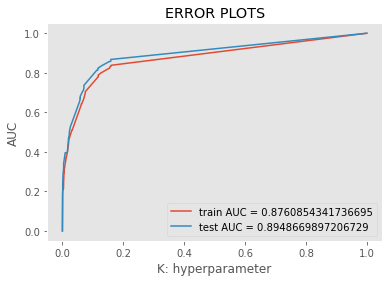

the maximum value of tpr*(1-fpr) 0.7035189075630253 for threshold 0.037
0.03714295928857714
Model test F1 score is :  0.4787878787878787
Model test AUC score is :  0.8948669897206729


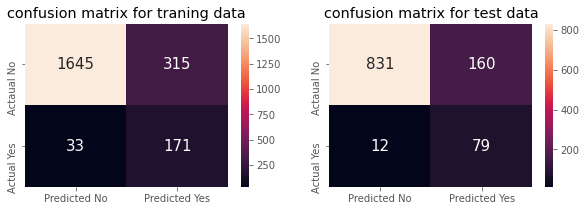

In [72]:
model_f1_score, model_AUC_score = model_performence_check(loaded_model1 ,trainmeta,testmeta,trainmetay,testmetay)

# **Performence evalution**

In [58]:
#https://github.com/rohansoni634/Healthcare-Provider-Fraud-Detection-Analysis/blob/master/Healthcare%20Provider%20Fraud%20Detection%20Analysis_EDA_First_cut_Models.ipynb
def model_comp(label=[],metric1=[],metric2=[],set_ylabel='',set_title='',metric1_label='',metric2_label=''):
    
    x = np.arange(len(model))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x - width/2, metric1, width, label=metric1_label,color = 'teal')
    rects2 = ax.bar(x + width/2, metric2, width, label=metric2_label)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(set_ylabel)
    ax.set_title(set_title)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()

    plt.show()

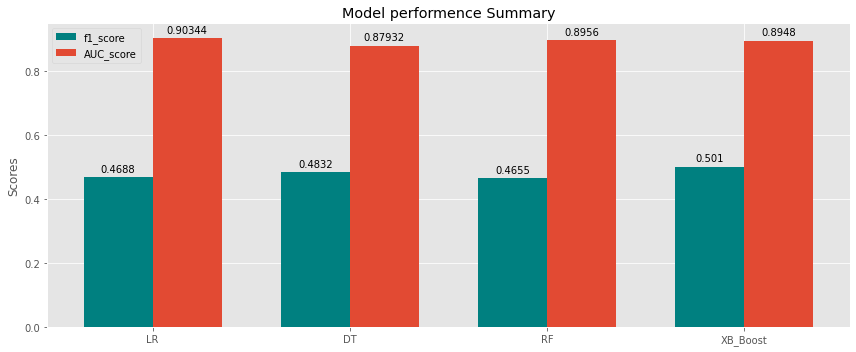

In [59]:
model = ['LR','DT','RF','XB_Boost']
f1_score = [0.4688,0.4832,0.4655,0.501]
AUC_score = [0.90344,0.87932,0.8956,0.8948]

model_comp(model,f1_score,AUC_score,'Scores','Model performence Summary','f1_score','AUC_score')